# Setting up training with codebase

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Example dummy agent.
- this agent holds its current position/vel
- doesn't do anything.
- used to show how to setup an agent.

In [16]:
import numpy as np
from air_hockey_challenge.framework import AgentBase


def build_agent(env_info, **kwargs):
    """
    Function where an Agent that controls the environments should be returned.
    The Agent should inherit from the mushroom_rl Agent base env.

    Args:
        env_info (dict): The environment information
        kwargs (any): Additionally setting from agent_config.yml
    Returns:
         (AgentBase) An instance of the Agent
    """

    return DummyAgent(env_info, **kwargs)

'''
    We will compute the action which is desired pos & vel.
'''

class DummyAgent(AgentBase):
    def __init__(self, env_info, **kwargs):
        super().__init__(env_info, **kwargs)
        self.new_start = True
        self.hold_position = None

    def reset(self):
        self.new_start = True
        self.hold_position = None

    def draw_action(self, obs):
        # breaking down observation into something we can use
        # self.get_joint_pos(obs), self.get_joint_vel(obs), self.get_puck_pos(obs)
        
        hold_position = self.get_joint_pos(observation)
        velocity = np.zeros_like(hold_position)
        action = np.vstack([hold_position, velocity])
        return action

### Setup PyTorch Neural Network to convert observation space to action space
### Requirements
- setup Policy Gradient Method
- setup Policy
    - have a neural network (we are learning that)
    - setup TorchApproximator (connect Torch with MushroomRL)
    - plug Approximator into a Parametric Policy
- Plug Policy into Policy Gradient Method
- Train

In [17]:
#super stupid forward pass neural network
class DefenseGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, use_cuda = False, dropout=False, activation = nn.LeakyReLU(0.1) ):
        super().__init__()
        
        num_layers = 20
        layer_width = 10
        
        
        layers = [nn.Linear(input_dim, layer_width), activation]
        for i in range(num_layers-1):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation)
        layers.append(nn.Linear(layer_width, output_dim))
        layers.append(activation)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, obs):
        out = self.model(obs.float())
        
        # return torch.reshape(out,6)
        return out

In [18]:
network = DefenseGenerator(8,6)
print(network(torch.zeros(1,8)).shape)

torch.Size([1, 6])


### Setup DeepDummy Agent

In [19]:
from mushroom_rl.algorithms.policy_search import REINFORCE
from mushroom_rl.policy.deterministic_policy import DeterministicPolicy
from mushroom_rl.policy.gaussian_policy import GaussianPolicy
from mushroom_rl.approximators.parametric import TorchApproximator
from mushroom_rl.utils.optimizers import AdaptiveOptimizer

/home/jyue86/anaconda3/envs/eecs298/lib/python3.8/site-packages/numpy_ml/rl_models/rl_utils.py:25: DependencyWarning: Agents in `numpy_ml.rl_models` use the OpenAI gym for training. To install the gym environments, run `pip install gym`. For more information, see https://github.com/openai/gym.
  warnings.warn(fstr, DependencyWarning)


In [47]:
#setting this up

import numpy as np
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore, CustomChallengeCore
from mushroom_rl.algorithms.policy_search import REINFORCE, GPOMDP, eNAC, RWR, PGPE, REPS, ConstrainedREPS, MORE
from mushroom_rl.distributions import GaussianCholeskyDistribution

search_method = "MORE"
log_path = f"/home/jyue86/Documents/air_hockey_challenge/experiments/policy_search/{search_method}"
def custom_reward_function(base_env, state, action, next_state, absorbing):
#     print("State:")
#     print(state)
#     print("======")
#     print("Action:")
#     print(action)
#     print("======")
#     print("Next State")
#     print(next_state)
#     print("======")
    reward_value = (state[0] - state[6]) * 2 + (1/abs(state[1] - state[7])) * 2 + absorbing * 3 + \
            (next_state[0] - next_state[6]) * 4 + (1/abs(next_state[0] - next_state[6]))
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(f"{reward_value}\n")
    print(reward_value)
    return reward_value

mdp = AirHockeyChallengeWrapper(env="3dof-defend", action_type="position-velocity", interpolation_order=3, custom_reward_function=custom_reward_function, debug=True)

approximator = TorchApproximator(input_shape=12,
                                 output_shape=6,
                                 network=DefenseGenerator,
                                 loss=F.smooth_l1_loss,
                                 # optimizer={'class': optim.Adam, 'params': {'lr': .001}},
                                 use_cuda=False)
policy = GaussianPolicy(approximator,torch.eye(6))
old_weights = policy.get_weights()

white_box_algorithm_params = {'mdp_info': mdp.info,
                    'policy': policy,
                    'optimizer':  AdaptiveOptimizer(eps=0.01)
                   }

mu = np.zeros(policy.weights_size)
sigma = 1e-3 * np.eye(policy.weights_size)
distribution = GaussianCholeskyDistribution(mu, sigma)
black_box_algorithm_params = {
    'mdp_info': mdp.info,
    'policy': policy,
    # 'optimizer':  AdaptiveOptimizer(eps=0.01),
    'distribution': distribution,
    'eps': 0.5,
    # 'beta': 0.07,
    'kappa': 5
}


reinforce = MORE(**black_box_algorithm_params)

core = CustomChallengeCore(reinforce, mdp)

core.learn(n_episodes=50, n_episodes_per_fit=10, render=False) #render allows us to visualize what's going on

                                                                                                                      
  0%|                                                                                          | 0/50 [00:00<?, ?it/s]

11.701956725854446
11.60966146803501
11.456330444633366
11.320454234211992
11.251474483444577
11.119791381339224
11.046081772268524
10.913674205595923
10.81248858079176
10.750309453299833
10.675176555913346
10.603087879118016
10.43099527062869
10.24685572153578
10.082375000755235
9.961330674489892
9.890901920300623
9.70810310160117
9.602476697100444
9.400427969072007
9.205719234050745
9.067900258958332
8.893872133566541
8.664838035704937
8.54823050277429
8.338710491009559
8.327778406833737
8.234969183746385
8.481631910194807
8.490014245438534
9.168735870444142
8.804226781838745
8.866562734828978
8.30781509782581
8.261471313481456
9.046724354603452
9.544677868797416
11.968634022369116
13.710707918075506
19.42255249520904
103.86365401655316
329.75524577305504
1133.6533306073097
42.29918741317878
39.18188202607328
25.87078173728783
47.01244492078499
495.16634612790784
80.21350823630945
1368.2113113793641
55.679702246685935
1205.0132178535412
58.5732003351903
38.84983937650859
915.27354544

  2%|█▋                                                                                | 1/50 [00:05<04:36,  5.64s/it]

4.984316679778578
5.361087345403816
5.623276728019129
6.041787684628122
5.517108946963809
4.72135962475766
4.326231326922409
3.608393641531281
3.4958227649750553
3.282778754842985
3.2070532260813254
4.732808625093688
13.099352536453967
41.7277680996784
11.326779217235671
11.154286262555807
11.040544013862936
10.919211920176426
10.724113628298586
10.544145538058416
10.42263688117345
10.268568352820536
10.057991120052677
9.930055005097715
9.753729072459887
9.650892773863573
9.583654922323849
9.444727586310952
9.261718677996337
9.175734689040324
8.943670450678704
8.834755994454502
8.622628707534874
8.440192437408028
8.31777816071896
8.148388532432978
7.93122137647308
7.779517745372866
7.69180364362158
7.556803156182244
7.331215696168185
7.5218990096874565
7.468489168939359
7.620211876045829
7.607136573576575
7.83744919219482
7.907048959407719
7.727435020987487
7.834578138731155
7.806747560938211
8.069406942408964
8.582180458059709
9.059007960268278
11.813345213588164
14.399951667777287
13

-2.280225596657701
-2.472438022459631
-3.371943591346832
-4.053855683924614
-3.329585349907429
-4.198986163010092
-4.045740726253905
-4.427396597813921
-4.38762492783909
-3.5564784559607454
-3.53083268629472
-3.496298168919888
-1.8699603069014428
0.6012004951018586
0.5344711371998094
2.6417674200254644
0.7529139265655446
1.332866675508218
1.1681836241870958
-1.072964836226377
-2.115675072737247
-2.453253049490648
-2.1440037331159334
-2.3137293654746176
-1.431293018958528
-0.8341842162528966
0.42947724482728633
1.6213855318874761
2.191680302357635
5.436575230730874
4.897283811337999
6.707401434039288
2.5115203634697165
2.0252696433948323
0.8939062191895126
1.0243655164642005
0.8000354573107997
1.0410759965898215
1.297820009550913
1.6949738261966232
1.5271918816702477
1.9362191692243427
7.060508647060731
23.412716735383068


  4%|███▎                                                                              | 2/50 [00:11<04:30,  5.63s/it]

28.97726934397568
10.317722616981735
6.21269063984067
4.310297694433411
3.3464982566324446
2.8186831238463332
2.522799088431386
2.466872202736633
2.6150197158043804
3.322709821823177
5.510922506521823
15.679687112255396
26.43589890665327
6.2621510257080315
5.119640010228407
5.0526380145549155
5.021293332841223
4.962771275797719
4.972372199829085
5.035318618016287
4.723950949225297
6.164240177347965
28.841405662900275
10.214338878564027
2.9644346908784547
1.3335870652322435
0.15556843457514713
-0.20066873092244575
10.854726491604495
10.683442945672711
10.50801587253991
10.319600805272454
10.096166050621884
9.947557537646073
9.811765891422471
9.709168973755146
9.569663676013963
9.429273607068993
9.270445241688455
9.033786510363809
8.784800187365178
8.54120069067395
8.367569358174803
8.187081346577218
7.998783708938756
7.765627874707969
7.560986926997273
7.442879573678191
7.234366089631615
7.074390624040066
6.989902422651553
6.918270928013635
6.991127923492232
7.104564642394006
7.35267636

  6%|████▉                                                                             | 3/50 [00:15<03:46,  4.82s/it]

4.283649379382741
4.8309211860026995
5.383205118450867
5.943953695858134
6.592501826097468
7.49364719491069
9.01186111435068
10.728282832520351
12.776409563300875
15.019477052773853
14.212659355524387
10.993451422284117
8.17133033648162
5.236757012505857
4.883472357269457
5.009673438203059
5.597980997944559
6.329988413001292
7.7141676798832615
7.641188427306684
6.73190644776885
6.352033196110037
6.6767244747737005
6.1410111378598415
5.936308252413533
4.807247741300416
5.309257056352651
9.354253963080783
31.336355426735942
28.030626020290217
10.503975182993598
9.769044725376789
11.189443348105511
10.97311703762706
10.765419033839486
10.628457263295429
10.404377173128127
10.247526100950678
10.159465445758403
9.962790577691523
9.825354868567834
9.681633889322878
9.57249885172655
9.531972149884668
9.441534513075268
9.197872794085885
8.980654748216292
8.643415050110608
8.270387918336992
7.979745471262396
7.8682546201259855
7.805175342993712
7.869753640515135
8.023560285449918
8.538963927719

  8%|██████▌                                                                           | 4/50 [00:18<03:14,  4.23s/it]

55.256909233435465
56.53347698022607
13.136163020185236
9.15723628400345
8.613371470916466
8.094123906137618
8.540012005963275
9.79119288142307
11.824358764981612
15.59079866655156
24.910385668094914
457.03480142158617
71.82280612677249
35.933581548579944
25.741679057186598
25.390601917044492
31.75094892158129
39.29111593530032
122.69584851400658
616.8507642483106
159.81759631153398
86.74323496468061
43.16769165332697
52.06559628149334
27.47591017864621
32.51694073039279
24.330608088602403
34.293112564787435
11.727441573909642
11.371166729294778
11.03503713692092
10.700303389353342
10.39592930010404
10.160054462109782
9.911480661472748
9.647223314750148
9.44847545023708
9.158954257647896
8.865639091581604
8.57361127144833
8.340661368425833
8.091943403440148
7.765600568602103
7.497486174450987
7.212525263048718
6.985575555127015
6.847525865535918
6.761771383831114
6.740031942524686
6.692571277626426
6.738423710917669
6.851959887276545
6.909433959832171
6.959668422925072
6.91140738032060

 10%|████████▏                                                                         | 5/50 [00:21<02:50,  3.78s/it]

6.767686922429466
6.859032025160775
9.89232309105978
11.926848853855015
11.7045825664548
11.401087878809772
11.200965554197559
10.989788876959121
10.776850187117414
10.53635164347776
10.355906050207967
10.137960649340782
9.935957893221248
9.662011018962547
9.467044881548897
9.26217892214994
9.066166115578831
8.927866671190138
8.663169515368297
8.404132771989797
8.166923135119553
7.8966229115772375
7.613173804672558
7.410777068387719
7.275295743707299
7.119905517886042
7.169121255085046
7.425403331926086
7.8645747805304715
9.28343828335009
13.167755404876633
18.45454375805101
45.81489148785438
71.30430388461771
19.47243058321032
16.543881463076026
16.364280459335845
18.31567061541281
21.582585845286815
18.874311927275752
161.62670215083693
8.232219910631683
1.4666062184166542
0.15032946417756454
-0.14818878722120976
-0.3601566875525237
-0.7100233965705516
-0.7254524636718818
-0.933338587067728
-0.7050669500704474
-0.5677304017057057
-0.3820266168265185
0.15204914542279568
0.416006447927

 12%|█████████▊                                                                        | 6/50 [00:26<03:00,  4.10s/it]

10.148434746446593
8.82765538188363
8.428313349594703
8.399996701330494
8.18574823734721
8.554586259059796
8.62630317456619
8.622572456791145
8.406910405001511
8.538500564730032
9.141591521688412
10.105266988943914
13.37785888380348
19.666946268327866
54.546223769781214
158.51519218810736
78.45850642088342
18.222589516510222
13.909352175783365
10.137858598612457
9.080252682579843
7.64066998761882
8.097418976041881
7.2518151546722684
8.628475982716516
8.533882825881031
8.507096283946856
9.183779950525887
8.780344013105607
10.83072683035242
13.756033656974768
16.422191776235035
26.5223699858082
34.439113587562886
79.15855022836887
102.52235222380203
10.93534497027946
10.655142933081994
10.40507124235696
10.133135076032623
9.791323463589542
9.481683138564101
9.270147278508546
8.999248472997055
8.79484659511513
8.582244534450872
8.424032295232575
8.163600514249785
7.978736993667729
7.694646344434826
7.5372373456002775
7.29248983750868
7.132420116054709
6.964680073734252
6.914042795342492
6

 14%|███████████▍                                                                      | 7/50 [00:30<02:58,  4.14s/it]

27.243009722530957
12.970769969799559
13.426089018854231
11.358530522000144
15.061557790902414
28.582383721255276
11.861486229597066
8.328354415986121
7.019703412897897
5.617731214137983
5.906042630585086
6.276990875528668
5.08205419201132
4.939310519125605
4.865012882986312
5.268332843004764
6.321082235374448
7.353409102484279
10.821422465004247
19.589862204560283
42.27540813033354
8058.204777278908
75.60324850389745
45.99633903638215
134.36071743590858
767.458673460944
39.426635186673096
86.1920382442156
111.66104351436277
38.070378753152376
18.207821796641934
20.164400959499382
22.97599904359427
16.950337920838308
18.685417084236487
14.690841082056558
13.745143223604758
19.52691603691747
11.258281223419717
10.958363967392014
10.666088536316977
10.399752213915885
10.218826518600139
9.988471227441504
9.817195800537622
9.593689907891543
9.319147476725234
9.140600734727622
8.94976060219339
8.68200881474932
8.470552308984363
8.206315777998041
7.949694947017641
7.714395876624897
7.5474589

 16%|█████████████                                                                     | 8/50 [00:34<02:58,  4.26s/it]

10.561418876752445
12.596617005451655
13.152666325394897
17.807699675497496
17.597517751170535
22.087119123675155
20.571894379185423
11.828551281050757
11.508295075638326
11.217200298404912
10.942245847864253
10.637887945957784
10.426924528204419
10.169872667968079
9.856244786294653
9.629338030188459
9.343981927176737
9.002388469436983
8.717829299730404
8.471470924520652
8.256082606236914
7.965408096264716
7.788207498138757
7.5284079759542335
7.5090906445079355
7.410505158947361
7.515246513347096
7.726284359407675
8.29121865330255
9.27431540269884
13.227166286936823
77.4396953196618
19.00550935008541
11.049630316495257
7.644198429013207
5.835315012420245
6.300531016940451
6.1182810247590576
7.5833797564839


 18%|██████████████▊                                                                   | 9/50 [00:37<02:36,  3.82s/it]

8.41739524719961
17.709912222974
24.124688735096548
44.99583054686112
23.129338611635205
25.85827726712014
94.65574205059984
47.213106716228395
866.5023565230429
56.98320716362508
52.32336437971739
25.58341112512321
14.33738266184276
14.03183804453963
14.845810092156784
15.328175254234697
18.98405809323931
21.616741820654518
20.36521659282853
28.70494498082058
122.45842723694206
17.225834527491365
19.95242293182445
19.477977069956378
26.03702310771154
12.05470287736537
11.718792352485952
11.478638688300677
11.13307748425933
10.911640008350808
10.677555582992682
10.42346329738179
10.108898323275852
9.847221171846847
9.572817065573862
9.363443642254994
9.227743758794087
8.977613532326819
8.788709148214318
8.569980221349214
8.276641715128353
8.03188618156372
7.7643701411358945
7.459406922315512
7.230414932361651
7.008456635675146
6.820067035815885
6.805117674561735
6.990436963390001
7.65850873909401
9.527017254477677
12.081661254661283
16.284329758224043
63.04373800241032
46.8996055483164

 20%|████████████████▏                                                                | 10/50 [00:41<02:28,  3.72s/it]

15.34973664052831
17.005862191417478
24.344156187971393


TypeError: '<' not supported between instances of 'complex' and 'float'

In [7]:
policy.get_weights()

In [21]:
import pickle

In [ ]:
with open(f"./experiments/policy_search/{search_method}_weights.pkl", "wb") as f:
    pickle.dump(policy.get_weights(), f)

In [35]:
with open(f"./experiments/policy_search/{search_method}_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    print(weights)

[ 0.03494566  0.00169963  0.00983157 ... -0.05088288 -0.03511268
 -0.01950458]


In [11]:
from matplotlib import pyplot as plt
import numpy as np

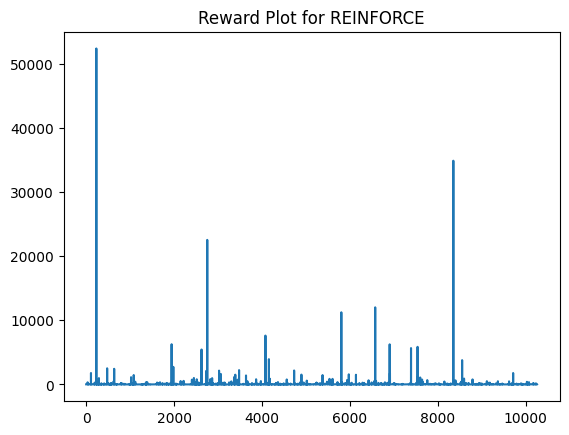

In [14]:
with open(f"./experiments/policy_search/REINFORCE", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for REINFORCE")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

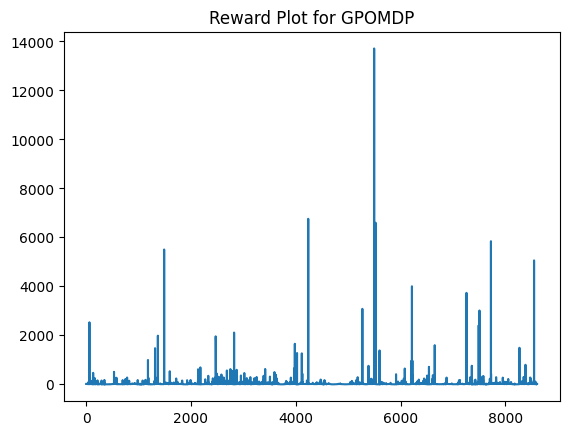

In [23]:
with open(f"./experiments/policy_search/GPOMDP", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for GPOMDP")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

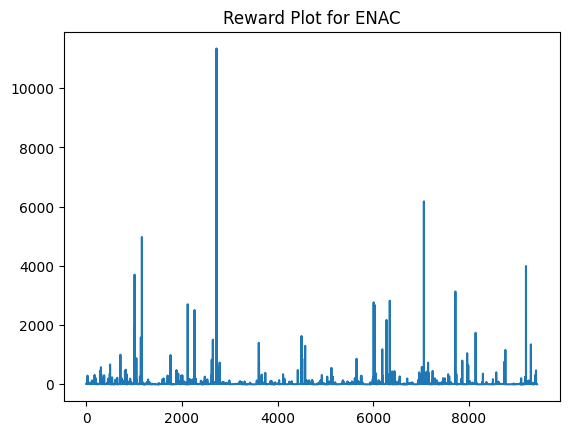

In [28]:
with open(f"./experiments/policy_search/eNAC", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for ENAC")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

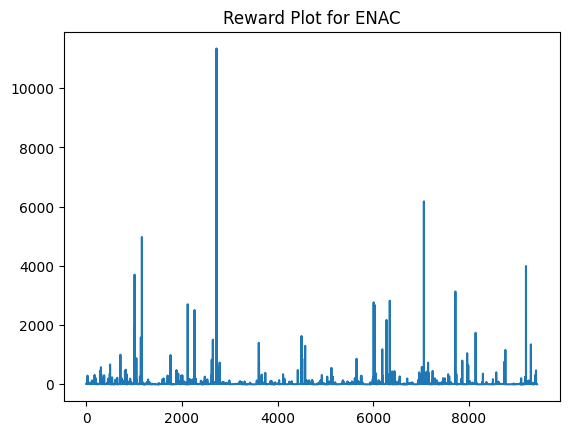

In [31]:
with open(f"./experiments/policy_search/eNAC", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for ENAC")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

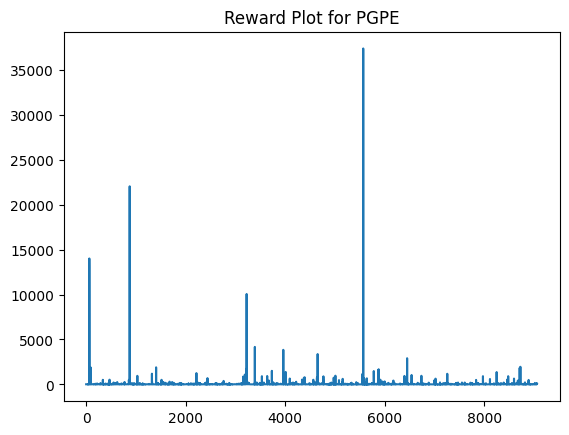

In [37]:
with open(f"./experiments/policy_search/PGPE", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for PGPE")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

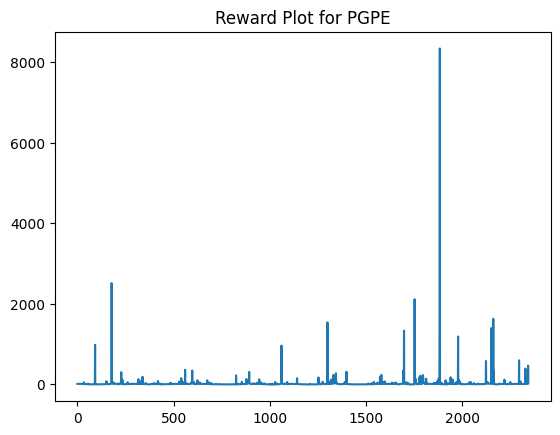

In [42]:
with open(f"./experiments/policy_search/REPS", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for PGPE")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

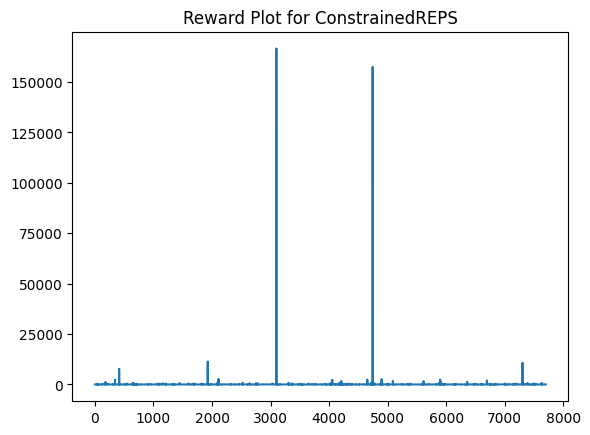

In [45]:
with open(f"./experiments/policy_search/ConstrainedREPS", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for ConstrainedREPS")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

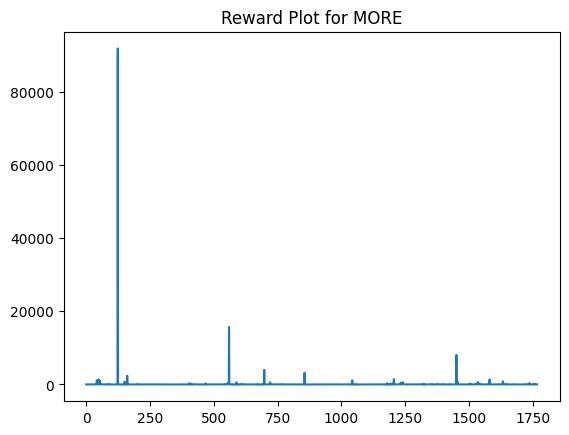

In [49]:
with open(f"./experiments/policy_search/MORE", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for MORE")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))